In [418]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score         #用随机森林进行特征选择
from sklearn.linear_model import Ridge                      #线性回归模型
#import lightgbm as lgb
from sklearn.model_selection import train_test_split        #
import xgboost as xgb 
from xgboost import plot_importance                         #用xgb的方法进行特征重要性筛选

In [419]:
#读取数据集
train_df = pd.read_csv("../input/train_data.csv",index_col=0)
test_df = pd.read_csv("../input/test_a.csv",index_col=0)

In [420]:
#feat_labels = train_df.columns[0:2]
#feat_labels.head()

In [421]:
train_df.head(5)
#train_df.shape

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


In [422]:
#test_df.head(10)
#test_df.shape

In [475]:
train_df["tradeMoney"].sort_values(ascending =False).head(10)      #true表示升序,false表示降序

ID
100007093    99999999.99
100028451    50000000.00
100042658    10000000.00
100022073      450000.00
100047710      450000.00
100084542      450000.00
100310820      450000.00
100012093      430000.00
100083675      380000.00
100089204      370000.00
Name: tradeMoney, dtype: float64

In [424]:
#查看一下tradeMoney值分布情况
train_df["tradeMoney"].sort_values(ascending =False).head(10)

ID
100007093    99999999.99
100028451    50000000.00
100042658    10000000.00
100022073      450000.00
100047710      450000.00
100084542      450000.00
100310820      450000.00
100012093      430000.00
100083675      380000.00
100089204      370000.00
Name: tradeMoney, dtype: float64

tradeMoney有离群点,对该列特征进行处理

In [425]:
#mean_tradeMoney = train_df["tradeMoney"].mean()
#train_df.loc[train_df["tradeMoney"] == 99999999.99,"tradeMoney"] = mean_tradeMoney
#train_df.loc[train_df["tradeMoney"] == 50000000.00,"tradeMoney"] = mean_tradeMoney
#train_df.loc[train_df["tradeMoney"] == 10000000.00,"tradeMoney"] = mean_tradeMoney

筛选交易额在100-10w之间的数据

In [426]:
#处理训练集中"tradeMoney"中的异常点
train_data = train_df[(train_df["tradeMoney"]>100)&(train_df["tradeMoney"]<100000)].copy()
print(train_data.shape[0])

41410


In [427]:
#处理训练集中"area"的异常点
#查看楼层
#train_df["totalFloor"].unique()
#发现有0层的,所以对totalFloor进行异常处理
train_1 = train_data[(train_data["area"]>10)&(train_data["area"]<1000)&(train_data["totalFloor"]>0)].copy()
#处理测试集中"area"的异常点
test_1 = test_df[(test_df["area"] > 10 ) &(test_df["area"]<1000)&(test_df["totalFloor"]>0)].copy()
train_1.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


In [428]:
y_train = train_1["tradeMoney"].copy()
y_train.shape[0]

40072

由此可见 测试集比训练集少了一列特征"tradeMoney",这就是我们测试集所要预测的label值

In [429]:
train_1.drop('tradeMoney',axis=1, inplace=True) 
train_1.shape

(40072, 49)

合并训练集和测试集,以方便进行处理

In [430]:
all_df = pd.concat((train_1, test_1), axis=0)

In [431]:
all_df.shape

(42541, 49)

In [432]:
#all_df.info()  #由此可见,除了"uv"特征和"pv"特征缺失20个以外,其他的不存在空的特征,因此无需对数据集进行填充.
all_df.isnull().sum().sort_values(ascending=False).head(10)

uv                  20
pv                  20
tradeTime            0
buildYear            0
gymNum               0
drugStoreNum         0
hospitalNum          0
privateSchoolNum     0
schoolNum            0
interSchoolNum       0
dtype: int64

In [433]:
all_df["rentType"].value_counts()

未知方式    32900
整租       5728
合租       3908
--          5
Name: rentType, dtype: int64

In [434]:
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0.0,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28
100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0.0,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16
100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,0.0,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22
100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,108037.8,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21
100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0.0,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18


In [435]:
all_df["houseType"].unique()  #查看一下,一共有多少种类型

array(['2室1厅1卫', '3室2厅2卫', '1室1厅1卫', '3室2厅3卫', '4室3厅3卫', '2室2厅1卫',
       '3室2厅1卫', '3室1厅1卫', '5室2厅3卫', '2室1厅2卫', '4室2厅2卫', '1室0厅1卫',
       '4室2厅3卫', '1室0厅0卫', '2室2厅2卫', '2室0厅1卫', '1室2厅1卫', '6室3厅4卫',
       '4室2厅4卫', '4室2厅1卫', '5室3厅5卫', '4室3厅2卫', '6室3厅2卫', '5室2厅2卫',
       '5室2厅4卫', '1室1厅2卫', '4室1厅3卫', '3室0厅1卫', '5室5厅4卫', '4室3厅5卫',
       '4室3厅4卫', '0室0厅1卫', '5室2厅5卫', '7室2厅3卫', '3室2厅4卫', '3室3厅2卫',
       '3室1厅2卫', '5室3厅4卫', '5室4厅5卫', '5室3厅3卫', '5室2厅6卫', '5室3厅1卫',
       '3室4厅4卫', '6室2厅4卫', '6室1厅4卫', '3室1厅3卫', '6室2厅3卫', '5室4厅3卫',
       '2室2厅3卫', '4室1厅1卫', '5室1厅1卫', '1室2厅2卫', '6室1厅1卫', '4室1厅2卫',
       '5室3厅6卫', '4室2厅5卫', '6室2厅2卫', '5室1厅2卫', '5室4厅4卫', '2室3厅1卫',
       '6室4厅2卫', '7室1厅7卫', '3室3厅4卫', '3室2厅5卫', '6室3厅5卫', '4室0厅1卫',
       '5室4厅2卫', '7室4厅3卫', '6室3厅3卫', '6室2厅5卫', '6室2厅7卫', '4室0厅4卫',
       '2室2厅0卫', '3室3厅3卫', '8室3厅4卫', '6室2厅6卫', '1室1厅0卫', '2室1厅0卫',
       '5室3厅2卫', '5室2厅1卫', '2室0厅0卫', '6室2厅1卫', '8室2厅4卫', '7室1厅1卫',
       '7室2厅1卫', '2室0厅2卫', '3室0厅2卫', '4室0厅2卫', '3室1厅0卫', '3室0厅

In [438]:
#all_df = pd.to_datetime(all_df["tradeTime"], format='%Y-%m-%d')
all_df["shi"] = all_df.houseType.astype('str').apply(lambda x:int(x[0:1]))
all_df["ting"] = all_df.houseType.astype('str').apply(lambda x:int(x[2:3]))
all_df["wei"] = all_df.houseType.astype('str').apply(lambda x:int(x[4:5]))

all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,shi,ting,wei
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,28248,614,111546,1124.0,284.0,0,2018/11/28,2,1,1
100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,14823,148,157552,701.0,22.0,1,2018/12/16,3,2,2
100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,77645,520,131744,57.0,20.0,1,2018/12/22,3,2,2
100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,8750,1665,253337,888.0,279.0,9,2018/12/21,1,1,1
100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,800,117,125309,2038.0,480.0,0,2018/11/18,3,2,3


查看数据集的函数: head,  info,  unique,  describe,  sort_values(),  value_counts(),  dtypes()

In [439]:
#特征处理:"houseFloor"
all_df["houseFloor"].unique()

array(['低', '中', '高'], dtype=object)

In [440]:
#用replace替换得到的1,2,3是object类型
#all_df["houseFloor"] =all_df["houseFloor"].replace("低",1)
#all_df["houseFloor"] =all_df["houseFloor"].replace("中",2)
#all_df["houseFloor"] =all_df["houseFloor"].replace("高",3)
all_df.loc[all_df["houseFloor"] == "低","houseFloor"] = 1
all_df.loc[all_df["houseFloor"] == "中","houseFloor"] = 2
all_df.loc[all_df["houseFloor"] == "高","houseFloor"] = 3
all_df["houseFloor"].unique()

array([1, 2, 3], dtype=int64)

In [441]:
#提取特征三:"totalFloor
all_df["totalFloor"].unique()

array([16, 14, 32, 17,  2, 18,  5,  6,  7, 21,  1,  3, 19, 29, 12,  8,  4,
       22, 30, 20, 24, 25, 26, 28, 15, 10, 11, 13, 33,  9, 23, 37, 27, 56,
       38, 40, 60, 35, 49, 41, 31, 62, 36, 53, 59, 39, 43, 61, 58, 51, 45,
       47, 34, 88], dtype=int64)

In [442]:
all_df["houseToward"].value_counts()
#没法处理暂时舍去
#all_df.drop('houseToward',axis=1, inplace=True) 
all_df["houseToward"]=all_df["houseToward"].replace("暂无数据","南")
all_df["houseToward"].value_counts()

南     36709
南北     2781
北      1263
东南      655
东       500
西南      320
西       223
西北       66
东西       24
Name: houseToward, dtype: int64

In [443]:
all_df["houseDecoration"].value_counts()  
#缺失值有点多,这个特征比较重要,但是目前没法处理,暂时舍去

其他    30978
精装     9966
简装     1270
毛坯      327
Name: houseDecoration, dtype: int64

In [444]:
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,shi,ting,wei
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,1,16,南,其他,XQ00051,SH,RG00001,...,28248,614,111546,1124.0,284.0,0,2018/11/28,2,1,1
100307942,125.55,未知方式,3室2厅2卫,2,14,南,简装,XQ00130,SH,RG00002,...,14823,148,157552,701.0,22.0,1,2018/12/16,3,2,2
100307764,132.00,未知方式,3室2厅2卫,1,32,南,其他,XQ00179,SH,RG00002,...,77645,520,131744,57.0,20.0,1,2018/12/22,3,2,2
100306518,57.00,未知方式,1室1厅1卫,2,17,南,精装,XQ00313,SH,RG00002,...,8750,1665,253337,888.0,279.0,9,2018/12/21,1,1,1
100305262,129.00,未知方式,3室2厅3卫,1,2,南,毛坯,XQ01257,SH,RG00003,...,800,117,125309,2038.0,480.0,0,2018/11/18,3,2,3


In [445]:
#all_df["communityName"].value_counts()   
#特征没法处理,暂时舍去
all_df.drop('communityName',axis=1, inplace=True) 

In [446]:
#all_df["city"].value_counts()
#由此可见,city只有一种,所以可以直接删去
all_df.drop('city',axis=1, inplace=True) 

In [447]:
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,region,plate,buildYear,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,shi,ting,wei
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,1,16,南,其他,RG00001,BK00064,1953,...,28248,614,111546,1124.0,284.0,0,2018/11/28,2,1,1
100307942,125.55,未知方式,3室2厅2卫,2,14,南,简装,RG00002,BK00049,2007,...,14823,148,157552,701.0,22.0,1,2018/12/16,3,2,2
100307764,132.00,未知方式,3室2厅2卫,1,32,南,其他,RG00002,BK00050,暂无信息,...,77645,520,131744,57.0,20.0,1,2018/12/22,3,2,2
100306518,57.00,未知方式,1室1厅1卫,2,17,南,精装,RG00002,BK00051,暂无信息,...,8750,1665,253337,888.0,279.0,9,2018/12/21,1,1,1
100305262,129.00,未知方式,3室2厅3卫,1,2,南,毛坯,RG00003,BK00044,暂无信息,...,800,117,125309,2038.0,480.0,0,2018/11/18,3,2,3


提取特征六:"region",直接one_hot处理

In [448]:
#all_df["region"].value_counts()

提取特征七:"plate"

In [449]:
all_df["plate"].unique()

array(['BK00064', 'BK00049', 'BK00050', 'BK00051', 'BK00044', 'BK00052',
       'BK00031', 'BK00028', 'BK00017', 'BK00045', 'BK00027', 'BK00041',
       'BK00047', 'BK00009', 'BK00025', 'BK00024', 'BK00014', 'BK00026',
       'BK00042', 'BK00046', 'BK00043', 'BK00013', 'BK00012', 'BK00005',
       'BK00011', 'BK00010', 'BK00003', 'BK00033', 'BK00053', 'BK00006',
       'BK00004', 'BK00002', 'BK00007', 'BK00015', 'BK00016', 'BK00019',
       'BK00030', 'BK00048', 'BK00018', 'BK00008', 'BK00029', 'BK00065',
       'BK00035', 'BK00036', 'BK00022', 'BK00023', 'BK00054', 'BK00038',
       'BK00037', 'BK00034', 'BK00058', 'BK00066', 'BK00039', 'BK00057',
       'BK00020', 'BK00059', 'BK00060', 'BK00063', 'BK00055', 'BK00061',
       'BK00040', 'BK00056', 'BK00062', 'BK00021', 'BK00032', 'BK00001'],
      dtype=object)

提取特征八:"buildYear"

In [450]:
all_df.loc[all_df["buildYear"] == "暂无信息","buildYear"] = 0

In [451]:
#all_df["buildYear"].value_counts()
all_df["buildYear"] =all_df["buildYear"].astype(int)
mean_col = all_df["buildYear"].mean()
print("-----------------------------------")
all_df["buildYear"] = all_df["buildYear"].replace(0,mean_col).astype(int)
all_df["buildYear"].unique()

-----------------------------------


array([1953, 2007, 1870, 2003, 2014, 1997, 1993, 1994, 1998, 2000, 1995,
       1999, 2015, 1981, 2002, 2010, 2011, 1989, 1983, 2001, 2012, 1996,
       2004, 2006, 2009, 2008, 1984, 2017, 1976, 1986, 1988, 1992, 2005,
       1987, 2016, 1965, 1990, 1985, 1978, 2013, 1980, 1954, 1982, 1968,
       1940, 1966, 1970, 1937, 1979, 1974, 1964, 1991, 1977, 1956, 1930,
       1952, 1957, 1936, 1967, 1972, 1975, 1955, 1949, 1912, 1958, 1973,
       1932, 1963, 1931, 1926, 1939, 1951, 1960, 1910, 1969, 1920, 1959,
       1962, 1961, 1950], dtype=int64)

to_datetime函数用法

In [452]:
#all_df["tradeTime1"] = pd.to_datetime(all_df["tradeTime"])
#all_df["tradeTime"].head()

split函数用法

In [453]:
#all_df["trade_time"] = all_df["tradeTime"].apply(lambda x: x.split("/"))    
#all_df["trade_time"].head()
all_df["trade_time"] = all_df.tradeTime.astype(str).apply(lambda x:int(x[0:4]))
all_df["trade_time"].astype(int)
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,region,plate,buildYear,...,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,shi,ting,wei,trade_time
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,1,16,南,其他,RG00001,BK00064,1953,...,614,111546,1124.0,284.0,0,2018/11/28,2,1,1,2018
100307942,125.55,未知方式,3室2厅2卫,2,14,南,简装,RG00002,BK00049,2007,...,148,157552,701.0,22.0,1,2018/12/16,3,2,2,2018
100307764,132.00,未知方式,3室2厅2卫,1,32,南,其他,RG00002,BK00050,1870,...,520,131744,57.0,20.0,1,2018/12/22,3,2,2,2018
100306518,57.00,未知方式,1室1厅1卫,2,17,南,精装,RG00002,BK00051,1870,...,1665,253337,888.0,279.0,9,2018/12/21,1,1,1,2018
100305262,129.00,未知方式,3室2厅3卫,1,2,南,毛坯,RG00003,BK00044,1870,...,117,125309,2038.0,480.0,0,2018/11/18,3,2,3,2018


In [454]:
print(all_df["trade_time"].dtypes)
print(all_df["buildYear"].dtypes)

int64
int32


In [455]:
all_df["trade_build"] =all_df["trade_time"] - all_df["buildYear"]
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,region,plate,buildYear,...,residentPopulation,pv,uv,lookNum,tradeTime,shi,ting,wei,trade_time,trade_build
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,1,16,南,其他,RG00001,BK00064,1953,...,111546,1124.0,284.0,0,2018/11/28,2,1,1,2018,65
100307942,125.55,未知方式,3室2厅2卫,2,14,南,简装,RG00002,BK00049,2007,...,157552,701.0,22.0,1,2018/12/16,3,2,2,2018,11
100307764,132.00,未知方式,3室2厅2卫,1,32,南,其他,RG00002,BK00050,1870,...,131744,57.0,20.0,1,2018/12/22,3,2,2,2018,148
100306518,57.00,未知方式,1室1厅1卫,2,17,南,精装,RG00002,BK00051,1870,...,253337,888.0,279.0,9,2018/12/21,1,1,1,2018,148
100305262,129.00,未知方式,3室2厅3卫,1,2,南,毛坯,RG00003,BK00044,1870,...,125309,2038.0,480.0,0,2018/11/18,3,2,3,2018,148


In [456]:
#all_df["pv"].value_counts()

后边特征都是数值型,不需要进行one_hot处理,只需处理日期和填补缺失值

In [457]:
#all_df["uv"].describe()
all_df["uv"] = all_df["uv"].fillna(all_df["uv"].mean())
#all_df["pv"].dtypes
all_df["pv"] = all_df["pv"].fillna(all_df["pv"].mean())
all_df.isnull().sum().sort_values(ascending=False).head(10)

trade_build       0
trade_time        0
superMarketNum    0
mallNum           0
parkNum           0
shopNum           0
bankNum           0
gymNum            0
drugStoreNum      0
hospitalNum       0
dtype: int64

In [458]:
def get_rate(row1,row2):
    return  row1/row2
    
all_df["pvuv"] = get_rate(all_df["pv"],all_df["uv"])
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,region,plate,buildYear,...,pv,uv,lookNum,tradeTime,shi,ting,wei,trade_time,trade_build,pvuv
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,1,16,南,其他,RG00001,BK00064,1953,...,1124.0,284.0,0,2018/11/28,2,1,1,2018,65,3.957746
100307942,125.55,未知方式,3室2厅2卫,2,14,南,简装,RG00002,BK00049,2007,...,701.0,22.0,1,2018/12/16,3,2,2,2018,11,31.863636
100307764,132.00,未知方式,3室2厅2卫,1,32,南,其他,RG00002,BK00050,1870,...,57.0,20.0,1,2018/12/22,3,2,2,2018,148,2.850000
100306518,57.00,未知方式,1室1厅1卫,2,17,南,精装,RG00002,BK00051,1870,...,888.0,279.0,9,2018/12/21,1,1,1,2018,148,3.182796
100305262,129.00,未知方式,3室2厅3卫,1,2,南,毛坯,RG00003,BK00044,1870,...,2038.0,480.0,0,2018/11/18,3,2,3,2018,148,4.245833


In [459]:
#日期很重要,但是暂时不知道怎么处理,后期再说
#all_df["tradeTime"] = pd.to_datetime(all_df["tradeTime"],format ="%Y/%m/%d")
#all_df["tradeTime"] = pd.to_datetime(all_df['tradeTime'],infer_datetime_format=True)

In [460]:
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,region,plate,buildYear,...,pv,uv,lookNum,tradeTime,shi,ting,wei,trade_time,trade_build,pvuv
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,1,16,南,其他,RG00001,BK00064,1953,...,1124.0,284.0,0,2018/11/28,2,1,1,2018,65,3.957746
100307942,125.55,未知方式,3室2厅2卫,2,14,南,简装,RG00002,BK00049,2007,...,701.0,22.0,1,2018/12/16,3,2,2,2018,11,31.863636
100307764,132.00,未知方式,3室2厅2卫,1,32,南,其他,RG00002,BK00050,1870,...,57.0,20.0,1,2018/12/22,3,2,2,2018,148,2.850000
100306518,57.00,未知方式,1室1厅1卫,2,17,南,精装,RG00002,BK00051,1870,...,888.0,279.0,9,2018/12/21,1,1,1,2018,148,3.182796
100305262,129.00,未知方式,3室2厅3卫,1,2,南,毛坯,RG00003,BK00044,1870,...,2038.0,480.0,0,2018/11/18,3,2,3,2018,148,4.245833


In [461]:
print(y_train.shape[0])

40072


In [462]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#x, y = train_data.iloc[:, 12:45].values, train_data.iloc[:, 49].values
x, y = all_df.iloc[:40072, 11:46].values, y_train.values
x_train, x_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
feat_labels = all_df.columns[11:46]
forest = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)
forest.fit(x_train, Y_train)


importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

#print(x_train.shape[1])

 1) lookNum                        0.436007
 2) tradeMeanPrice                 0.046312
 3) tradeSecNum                    0.043496
 4) totalTradeArea                 0.043049
 5) totalTradeMoney                0.039103
 6) uv                             0.038872
 7) pv                             0.036248
 8) tradeNewMeanPrice              0.036234
 9) remainNewNum                   0.035232
10) totalNewTradeMoney             0.030138
11) totalNewTradeArea              0.029387
12) tradeNewNum                    0.026360
13) newWorkers                     0.013476
14) gymNum                         0.011752
15) shopNum                        0.010992
16) totalWorkers                   0.010717
17) superMarketNum                 0.010621
18) mallNum                        0.009860
19) supplyNewNum                   0.009187
20) drugStoreNum                   0.007648
21) residentPopulation             0.007455
22) interSchoolNum                 0.006911
23) privateSchoolNum            

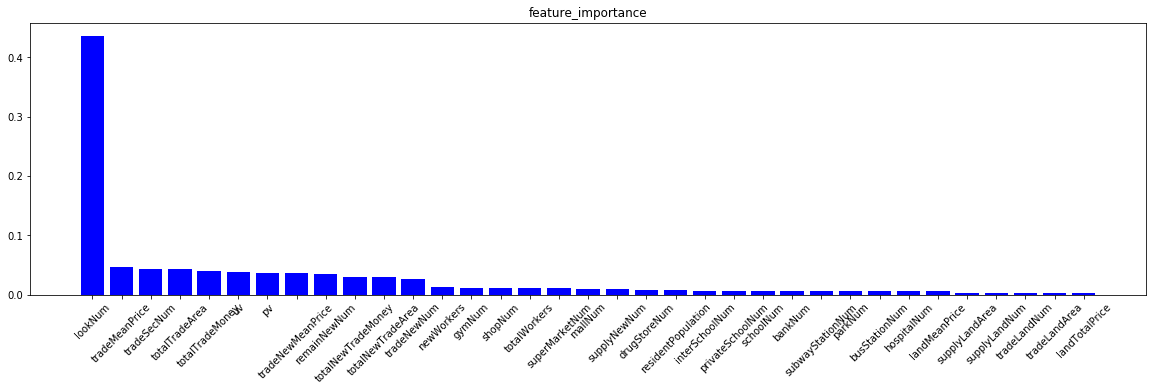

In [463]:
import matplotlib.pyplot as plt
#plt.title("feature_importance")
#plt.bar(range(x_train.shape[1]),importances[indices],color = "lightblue",align = "center")
#plt.xticks(,feat_labels,rotation = 90)
#plt.xlim([-1,x_train.shape[1]])
#plt.tight_layout()
#ply.show()
#以下代码参考泰坦尼克号案例
fig = plt.figure(figsize=(20,5))
plt.title("feature_importance")
plt.bar(range(x_train.shape[1]), importances[indices],color = "blue",align = "center")
plt.xticks(range(x_train.shape[1]), feat_labels[indices], rotation=45)
plt.show()

In [464]:
feature =all_df[["area","houseType","houseFloor","totalFloor","houseToward","region","plate","trade_build","shi","ting","wei","pv","lookNum"]].copy()
feature.shape[1]

13

In [ ]:
dummy_train_df = feature.loc[train_1.index]   #one_hot处理后的训练集
dummy_test_df = feature.loc[test_1.index]     #one_hot处理后的测试集

In [465]:
all_dummy_df = pd.get_dummies(feature)
all_dummy_df.head()

,area,houseFloor,totalFloor,trade_build,shi,ting,wei,pv,lookNum,houseType_0室0厅1卫,...,plate_BK00057,plate_BK00058,plate_BK00059,plate_BK00060,plate_BK00061,plate_BK00062,plate_BK00063,plate_BK00064,plate_BK00065,plate_BK00066
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,1,16,65,2,1,1,1124.0,0,0,...,0,0,0,0,0,0,0,1,0,0
100307942,125.55,2,14,11,3,2,2,701.0,1,0,...,0,0,0,0,0,0,0,0,0,0
100307764,132.00,1,32,148,3,2,2,57.0,1,0,...,0,0,0,0,0,0,0,0,0,0
100306518,57.00,2,17,148,1,1,1,888.0,9,0,...,0,0,0,0,0,0,0,0,0,0
100305262,129.00,1,2,148,3,2,3,2038.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [466]:
print(y_train.shape)

(40072,)


In [467]:
dummy_train_df = all_dummy_df.loc[train_1.index]   #one_hot处理后的训练集
dummy_test_df = all_dummy_df.loc[test_1.index]     #one_hot处理后的测试集

In [468]:
#print(dummy_train_df.shape)
y_train.shape[0]

40072

# 建立模型

In [469]:

X_train, X_test, y_train, y_test = train_test_split(dummy_train_df, y_train, test_size=0.2, random_state=0)
 
model = xgb.XGBRegressor(
    max_depth=5, 
    learning_rate=0.1, 
    n_estimators=160, 
    silent=True, 
    objective='reg:gamma')
model.fit(X_train, y_train)
 
# 对测试集进行预测
ans = model.predict(X_test)
 
# 显示重要特征
#plot_importance(model)
#plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [470]:
y_pro = model.predict(dummy_test_df)

In [471]:
submission_df = pd.DataFrame(data = y_pro)
#submission_df.head()

In [472]:
submission_df.to_csv("C:/Users/Administrator/future/output/submit.csv",index =None,header =None)

In [473]:
submission_df.head(5)

,0
0,3683.885498
1,4902.681641
2,5613.527344
3,3720.058594
4,5003.881348
